# 1. Instalação de dependências

In [1]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


import joblib

# 3. Função de limpeza de texto

In [3]:
def clean_text(text):
  if not isinstance(text, str):
      return ""
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\w+|#", " ", text)
  text = re.sub(r"[^a-záàâãéèêíïóôõöúçñ\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

# 4. Tratamento de Negações

In [4]:
def handle_negations(text):
  if not isinstance(text, str):
    return ""
  patterns = [
    r"\bnão\s+(\w+)",
    r"\bnao\s+(\w+)",
    r"\bnunca\s+(\w+)",
    r"\bjamais\s+(\w+)"
  ]
  for p in patterns:
      text = re.sub(p, r"nao_\1", text)
  return text

# 5. Tratamento de Intensificadores

In [5]:
def handle_intensifiers(text):
  if not isinstance(text, str):
    return ""
  intensifiers = r"(muito|bem|super|extremamente|bastante|totalmente)"
  text = re.sub(
      rf"\b{intensifiers}\s+(ruim|péssimo|horrível|insatisfeito|decepcionado|bom|ótimo|excelente|confuso)",
      r"\1_\2",
      text
  )
  return text


# 6. Pipeline único de pré-processamento

6.1 Colapsar intensificador + polaridade

In [6]:
def preprocess_text(text):
  text = clean_text(text)
  text = handle_negations(text)
  text = handle_intensifiers(text)
  return text


6.2 Colapso semântico de eventos negativos

In [7]:
# 6.2 Colapso semântico de eventos negativos
def handle_negative_events(text):
    """
    Junta substantivo + evento negativo.
    Ex:
    'entrega atrasou' -> 'entrega_atrasou'
    'caixa amassada'  -> 'caixa_amassada'
    """
    if not isinstance(text, str):
        return ""

    patterns = [
        r"\b(entrega)\s+(atrasou|demorou)",
        r"\b(caixa|produto)\s+(amassada|quebrada|danificada)",
        r"\b(problema)\s+(persistiu|continua)",
    ]

    for p in patterns:
        text = re.sub(p, r"\1_\2", text)

    return text


# 7. Normalização de colunas (fallback)

In [8]:
def normalize_columns(df):
  rename_map = {
    'texto': 'text', 'comentario': 'text', 'comentário': 'text', 'review': 'text',
    'sentimento': 'label', 'classe': 'label', 'rotulo': 'label', 'sentiment': 'label'
  }
  df = df.rename(columns={old: new for old, new in rename_map.items() if old in df.columns})
  if 'text' not in df.columns or 'label' not in df.columns:
      raise ValueError("CSV precisa conter colunas de texto e rótulo")
  return df[['text', 'label']]

# 8. Carregamento do dataset

In [9]:
from google.colab import files
import io


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",
  on_bad_lines="skip"
)


df = normalize_columns(df)
print("Total de registros carregados:", len(df))
display(df.head())


Saving data.csv to data.csv
Total de registros carregados: 3158


,text,label
0,"Produto excelente, chegou rápido e bem embalad...",Positivo
1,"Chegou com defeito, tive que devolver. Péssimo.",Negativo
2,"Entrega no prazo, mas a embalagem veio amassada.",Neutro
3,"Amei demais! Cor perfeita, material ótimo.",Positivo
4,"Demorou 20 dias pra chegar, nunca mais compro ...",Negativo


# 9. Limpeza e pré-processamento dos dados

In [10]:

df['text_clean'] = df['text'].apply(preprocess_text)
df = df[df['text_clean'] != ""]
df['label'] = df['label'].str.strip().str.capitalize()

print(df['label'].value_counts())



label
Negativo    1382
Positivo    1146
Neutro       629
Name: count, dtype: int64


# 10. Divisão treino / teste (ANTES do oversampling)

In [11]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Oversampling manual apenas no treino

In [12]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
majority_size = train_df['label'].value_counts().max()


balanced_parts = []
for label in train_df['label'].unique():
  subset = train_df[train_df['label'] == label]
  subset_upsampled = resample(
    subset,
    replace=True,
    n_samples=majority_size,
    random_state=42
  )
  balanced_parts.append(subset_upsampled)


train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)
print("Distribuição após oversampling (treino):")
print(train_balanced['label'].value_counts())

Distribuição após oversampling (treino):
label
Neutro      1105
Negativo    1105
Positivo    1105
Name: count, dtype: int64


# 12. Vetorização TF-IDF

In [13]:
tfidf = TfidfVectorizer(
  ngram_range=(1,2),
  min_df=2,
  max_df=0.9,
  sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 13. Treinamento dos modelos

In [14]:
lr_model = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model.fit(X_train_tfidf, y_train_bal)
svm_model.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 14. Avaliação (métricas confiáveis)

In [15]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)


print('Acurácia LR:', accuracy_score(y_test, y_pred_lr))
print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))


print('\nRelatório Regressão Logística:\n')
print(classification_report(y_test, y_pred_lr, digits=4))


print('\nRelatório SVM Linear:\n')
print(classification_report(y_test, y_pred_svm, digits=4))

Acurácia LR: 0.9525316455696202
Acurácia SVM: 0.9636075949367089

Relatório Regressão Logística:

              precision    recall  f1-score   support

    Negativo     0.9736    0.9314    0.9520       277
      Neutro     0.9098    0.9603    0.9344       126
    Positivo     0.9530    0.9738    0.9633       229

    accuracy                         0.9525       632
   macro avg     0.9455    0.9552    0.9499       632
weighted avg     0.9534    0.9525    0.9526       632


Relatório SVM Linear:

              precision    recall  f1-score   support

    Negativo     0.9887    0.9458    0.9668       277
      Neutro     0.9308    0.9603    0.9453       126
    Positivo     0.9536    0.9869    0.9700       229

    accuracy                         0.9636       632
   macro avg     0.9577    0.9644    0.9607       632
weighted avg     0.9644    0.9636    0.9637       632



# 15. Matrizes de confusão

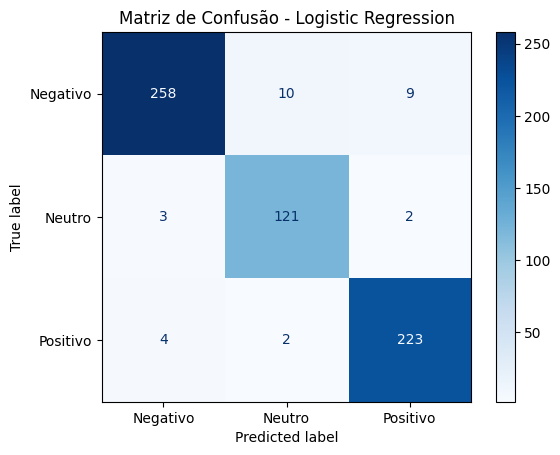

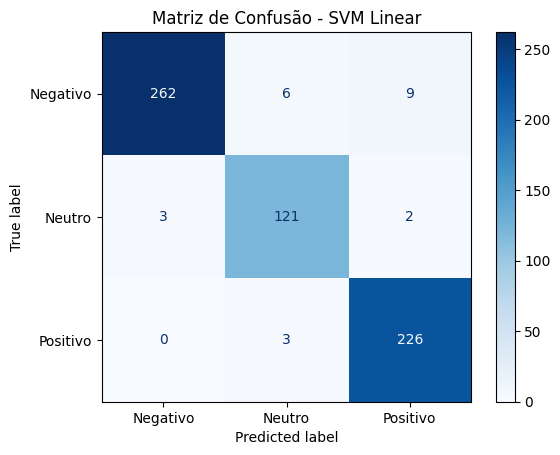

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Matriz de Confusão - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.grid(False)
plt.show()


# ===== Matriz de Confusão - SVM Linear =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM Linear')
plt.grid(False)
plt.show()


# 16. Comparação gráfica: LR vs SVM

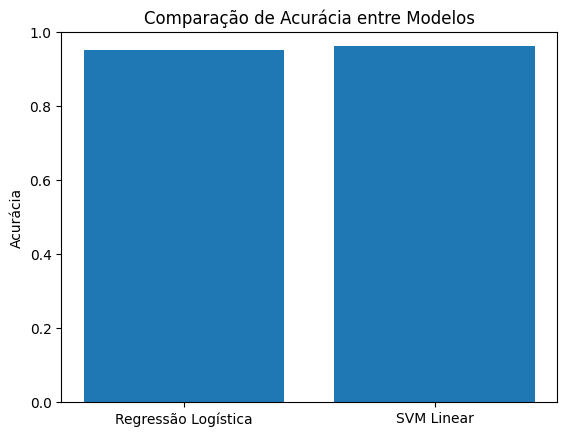

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predições (garantia contra erro de execução fora de ordem)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Cálculo das acurácias
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Dados para o gráfico
models = ['Regressão Logística', 'SVM Linear']
accuracy_scores = [acc_lr, acc_svm]

# Gráfico de barras
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # padrão para métricas de classificação
plt.show()



# 17. Validação Cruzada Estratificada

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_cv_scores = cross_val_score(
  lr_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


svm_cv_scores = cross_val_score(
  svm_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


print('LR - Média F1:', lr_cv_scores.mean())
print('SVM - Média F1:', svm_cv_scores.mean())

LR - Média F1: 0.9788706799058569
SVM - Média F1: 0.9849141180376538


# 18. Teste prático – frases novas

In [20]:
frases_teste = [
  "Muito insatisfeito  com o atendimento. Não resolveram meu problema.",
  "Não gostei. A cor é muito diferente da foto do anúncio.",
  "Produto fraco, não tancou.",
  "Produto cumpre o que promete.",
  "Simplesmente fantástico, superou todas as minhas expectativas!",
  "Veio quebrado, quero meu dinheiro de volta imediatamente."
]


frases_proc = [preprocess_text(f) for f in frases_teste]
frases_vec = tfidf.transform(frases_proc)


predicoes = lr_model.predict(frases_vec)
probs = lr_model.predict_proba(frases_vec)


pd.DataFrame({
    'Texto': frases_teste,
    'Predição': predicoes,
    'Confiança': probs.max(axis=1)
})

,Texto,Predição,Confiança
0,Muito insatisfeito com o atendimento. Não res...,Negativo,0.704237
1,Não gostei. A cor é muito diferente da foto do...,Negativo,0.451203
2,"Produto fraco, não tancou.",Negativo,0.817860
3,Produto cumpre o que promete.,Neutro,0.841109
4,"Simplesmente fantástico, superou todas as minh...",Positivo,0.818307
5,"Veio quebrado, quero meu dinheiro de volta ime...",Negativo,0.950065


# 20. Explicabilidade – filtro semântico

20.1 Termos neutros para EXPLICAÇÃO

In [21]:
# Cria lista de tokens neutros

NEUTRAL_EXPLANATION_TOKENS = {
    "de", "do", "da", "dos", "das",
    "em", "no", "na", "nos", "nas",
    "antes", "bem", "muito",
    "mas", "porém", "contudo"
}


20.2 Função para filtrar tokens irrelevantes

In [22]:
# Filtra tokens que tenham relevância
def is_relevant_explanation_token(token):
    """
    Define se um token deve aparecer na explicação.
    Não afeta treino nem predição.
    """

    # Remove unigramas neutros
    if token in NEUTRAL_EXPLANATION_TOKENS:
        return False

    # Remove bigramas formados só por neutros
    if "_" in token:
        parts = token.split("_")
        if all(p in NEUTRAL_EXPLANATION_TOKENS for p in parts):
            return False

    return True


20.3 Função de explicação baseada na Regressão Logística

In [23]:
# Gerando a explicação

def explain_prediction_lr(text, model, vectorizer, top_n=5):
    """
    Retorna classe, confiança e tokens que favoreceram/prejudicaram
    """

    text_proc = preprocess_text(text)
    vec = vectorizer.transform([text_proc])

    # Predição
    pred_class = model.predict(vec)[0]
    probs = model.predict_proba(vec)[0]
    confidence = probs.max()

    # Coeficientes
    feature_names = vectorizer.get_feature_names_out()
    class_index = list(model.classes_).index(pred_class)
    coefs = model.coef_[class_index]

    # Tokens presentes no texto
    present_indices = vec.nonzero()[1]

    contributions = []
    for idx in present_indices:
        token = feature_names[idx]
        weight = coefs[idx]

        # FILTRO AQUI (🔥 ponto-chave)
        if not is_relevant_explanation_token(token):
            continue

        if weight > 0:
            effect = "favorece"
        else:
            effect = "prejudica"

        magnitude = abs(weight)
        if magnitude > 1:
            impact = "alta"
        elif magnitude > 0.3:
            impact = "media"
        else:
            impact = "baixa"

        contributions.append((token, effect, impact, round(weight, 3)))

    # Ordena por impacto
    contributions = sorted(
        contributions,
        key=lambda x: abs(x[3]),
        reverse=True
    )[:top_n]

    return {
        "classe": pred_class,
        "confianca": round(confidence * 100, 1),
        "explicacao": contributions
    }


20.4 Teste com frases problemáticas

In [24]:
# Teste com frases problemáticas

frases_problema = [
    "O hotel era confortável e limpo, mas o café da manhã deixou a desejar.",
    "O produto chegou antes do prazo e funciona bem, porém a embalagem estava danificada.",
    "O atendimento foi péssimo e muito lento, mas o local era bem organizado."
]

for frase in frases_problema:
    resultado = explain_prediction_lr(frase, lr_model, tfidf)

    print(f"\n{resultado['classe']} ({resultado['confianca']}%)")
    print(frase)
    for t in resultado["explicacao"]:
        print(f"{t[0]} ({t[1]}, {t[2]}, {t[3]})")



Negativo (62.9%)
O hotel era confortável e limpo, mas o café da manhã deixou a desejar.
era (favorece, media, 0.631)
deixou (favorece, media, 0.628)
confortável (favorece, baixa, 0.151)

Positivo (42.4%)
O produto chegou antes do prazo e funciona bem, porém a embalagem estava danificada.
antes do (favorece, alta, 1.536)
chegou (favorece, alta, 1.48)
chegou antes (favorece, alta, 1.261)
embalagem (prejudica, media, -0.814)
do prazo (favorece, media, 0.706)

Negativo (47.8%)
O atendimento foi péssimo e muito lento, mas o local era bem organizado.
péssimo (favorece, alta, 1.679)
era (favorece, media, 0.631)
atendimento (favorece, baixa, 0.116)
lento (prejudica, baixa, -0.11)
lento mas (prejudica, baixa, -0.11)


# 21. Salvando modelos

In [25]:
import os
import joblib

# Criar pasta 'models' se não existir
os.makedirs('models', exist_ok=True)

# Salvar os modelos e o vetor TF-IDF
joblib.dump(lr_model, 'models/modelo_lr_sentimentos_V4.pkl')
joblib.dump(svm_model, 'models/modelo_svm_sentimentos_V4.pkl')
joblib.dump(tfidf, 'models/tfidf_V4.pkl')

print("Tudo pronto para testes com os modelos salvos ✅")

Tudo pronto para testes com os modelos salvos ✅
